# Checking Model Calibration

In [94]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, \
                            recall_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.preprocessing import StandardScaler

%matplotlib inline


In [132]:
try:
    data = pd.read_csv("data/processed_data.csv")

except FileNotFoundError:
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'

    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

data = data.astype(float)

# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

feature_names = X.columns.tolist()

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training Dataset Samples: {len(X_train)}")
print(f"Validation Dataset Samples: {len(X_validate)}")
print(f"Testing Dataset Samples: {len(X_test)}")

Training Dataset Samples: 569
Validation Dataset Samples: 143
Testing Dataset Samples: 179


In [ ]:

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_validate)

The first major step is predicting the probabilities of survival. 

In [96]:
y_calibrate_probabilities = model.predict_proba(X_validate)[:,1]
y_calibrate_probabilities

array([2.05822676e-01, 3.52452919e-02, 9.60064888e-01, 9.88666415e-01,
       2.01759231e-03, 3.81041132e-02, 9.79259014e-01, 9.98046637e-01,
       2.01433767e-02, 3.72755504e-03, 9.89065170e-01, 1.33913994e-01,
       3.56350005e-01, 9.77980614e-01, 9.99136150e-01, 3.38162435e-03,
       1.04845390e-02, 3.55994864e-03, 3.69379260e-02, 1.35302618e-01,
       9.92524981e-01, 8.23074400e-01, 7.01691031e-01, 9.22003865e-01,
       9.63228106e-01, 3.20929438e-02, 1.01891626e-03, 9.91041601e-01,
       5.07083893e-01, 1.61430892e-03, 9.04381633e-01, 9.59128499e-01,
       2.63705608e-02, 1.39667233e-03, 7.53330241e-04, 1.13243781e-01,
       6.23617694e-02, 5.43069188e-03, 1.52443694e-02, 9.99328375e-01,
       9.59980607e-01, 5.96146807e-02, 9.97057915e-01, 2.48304289e-02,
       9.97931361e-01, 9.61281121e-01, 5.95116755e-03, 5.50567806e-02,
       5.32550991e-01, 7.36888684e-03, 6.07086957e-01, 2.72897142e-03,
       2.00232957e-03, 2.91303862e-02, 8.32613051e-01, 9.96867716e-01,
      

## Manual Calculation - equal-width bins

Now we can create a reliability plot, binning cases by their predicted probability fo survival. 

In [97]:
# Bin data with numpy digitize (this will assign a bin to each case)
step = 0.10
bins = np.arange(step, 1+step, step)
digitized = np.digitize(y_calibrate_probabilities, bins)

# Put data in DataFrame
reliability = pd.DataFrame()
reliability['bin'] = digitized
reliability['probability'] = y_calibrate_probabilities
reliability['observed'] = y_validate.values

# Summarise data by bin in new dataframe
reliability_summary = pd.DataFrame()

# Add bins to summary
reliability_summary['bin'] = bins

# Calculate mean of predicted probability of survival for each bin
reliability_summary['confidence'] = \
    reliability.groupby('bin').mean()['probability']

# Calculate the proportion of passengers who survive in each bin
reliability_summary['fraction_positive'] = \
    reliability.groupby('bin').mean()['observed']

reliability_summary

,bin,confidence,fraction_positive
0,0.1,0.026164,0.171875
1,0.2,0.137591,0.117647
2,0.3,0.234026,0.333333
3,0.4,0.336645,0.000000
4,0.5,0.476205,0.500000
5,0.6,0.519817,1.000000
6,0.7,0.650163,0.000000
7,0.8,0.726074,0.000000
8,0.9,0.839273,0.250000
9,1.0,0.978974,0.904762


Let's now observe this on a plot.

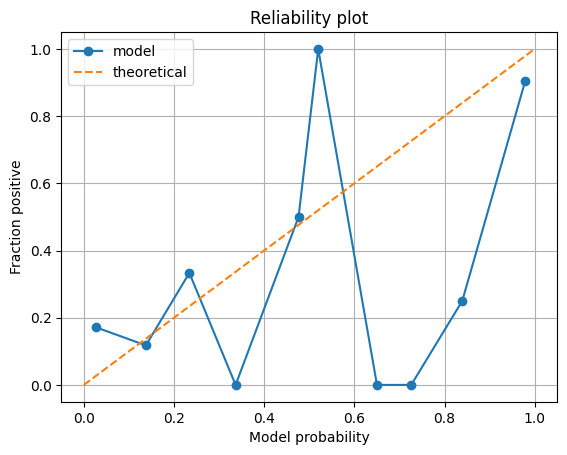

In [98]:
plt.plot(reliability_summary['confidence'],
         reliability_summary['fraction_positive'],
         linestyle='-',
         marker='o',
         label='model')

plt.plot([0,1],[0,1],
         linestyle='--',
         label='theoretical')

plt.xlabel('Model probability')
plt.ylabel('Fraction positive')

plt.title('Reliability plot')

plt.grid()
plt.legend()
plt.show()

## The sklearn reliability plot

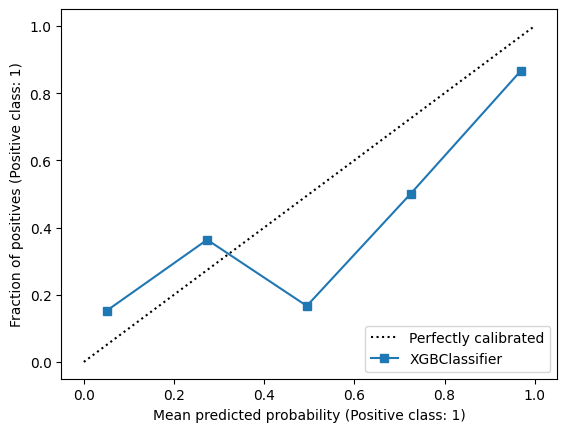

In [99]:
CalibrationDisplay.from_estimator(model, X_test, y_test)
plt.show()

Let's compare this for a series of classifiers.

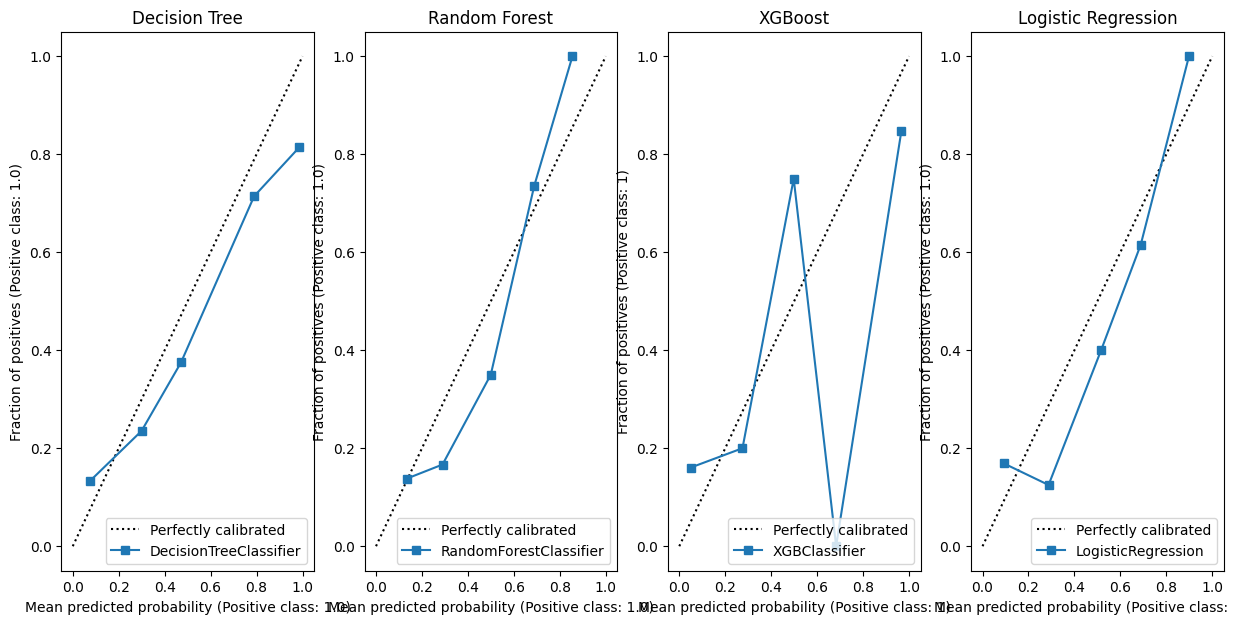

In [100]:
model_dt = DecisionTreeClassifier(max_depth=6)
model_rf = RandomForestClassifier(random_state=42, max_depth=6)
model_xgb = XGBClassifier(random_state=42)
model_lr = LogisticRegression()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 7))

#######################
# Decision Tree       #
#######################

CalibrationDisplay.from_estimator(model_dt.fit(X_train, y_train), X_validate, y_validate, ax=ax1)
ax1 = ax1.set_title("Decision Tree")

#######################
# Random Forest       #
#######################

CalibrationDisplay.from_estimator(model_rf.fit(X_train, y_train), X_validate, y_validate, ax=ax2)
ax2 = ax2.set_title("Random Forest")

#######################
# XGBoost             #
#######################

CalibrationDisplay.from_estimator(model_xgb.fit(X_train, y_train), X_validate, y_validate, ax=ax3)
ax3 = ax3.set_title("XGBoost")

#######################
# Logistic Regression #
#######################

# Initialise a new scaling object for normalising input data
sc = StandardScaler()

# Apply the scaler to the training and test sets
train_std=sc.fit_transform(X_train)
val_std = sc.fit_transform(X_validate)
test_std=sc.fit_transform(X_test)

CalibrationDisplay.from_estimator(model_lr.fit(train_std, y_train), val_std , y_validate, ax=ax4)
ax4 = ax4.set_title("Logistic Regression")

Repeat this, plotting them overlaid.

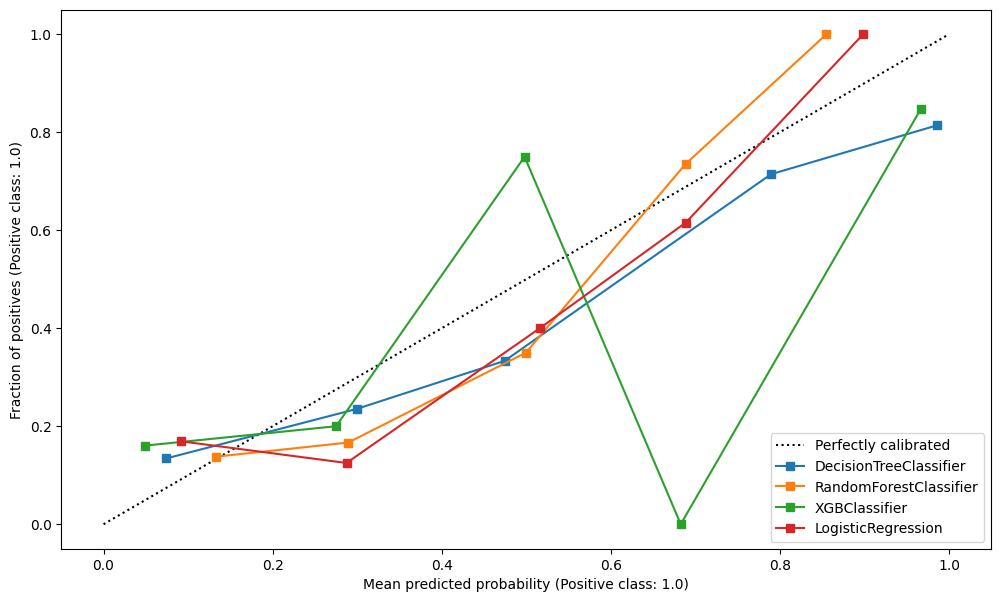

In [101]:
fig, ax = plt.subplots(figsize=(12,7))
CalibrationDisplay.from_estimator(model_dt.fit(X_train, y_train), X_validate, y_validate, ax=ax)
CalibrationDisplay.from_estimator(model_rf.fit(X_train, y_train), X_validate, y_validate, ax=ax)
CalibrationDisplay.from_estimator(model_xgb.fit(X_train, y_train), X_validate, y_validate, ax=ax)
CalibrationDisplay.from_estimator(model_lr.fit(train_std, y_train), val_std , y_validate, ax=ax)


### Histograms

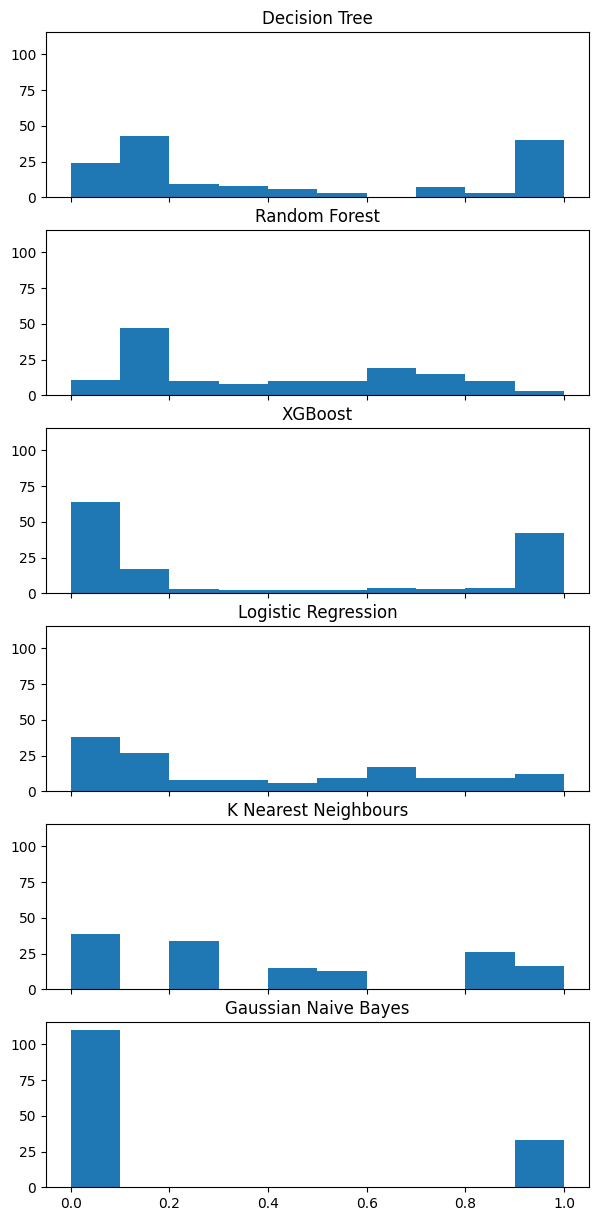

In [102]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(7, 15), sharey=True, sharex=True)

#######################
# Decision Tree       #
#######################

ax1.hist(model_dt.predict_proba(X_validate)[:,1], bins=np.arange(0,1.01,0.1))
ax1 = ax1.set_title("Decision Tree")

#######################
# Random Forest       #
#######################

ax2.hist(model_rf.predict_proba(X_validate)[:,1], bins=np.arange(0,1.01,0.1))
ax2 = ax2.set_title("Random Forest")

#######################
# XGBoost             #
#######################

ax3.hist(model_xgb.predict_proba(X_validate)[:,1], bins=np.arange(0,1.01,0.1))
ax3 = ax3.set_title("XGBoost")

#######################
# Logistic Regression #
#######################

ax4.hist(model_lr.predict_proba(val_std)[:,1], bins=np.arange(0,1.01,0.1))
ax4 = ax4.set_title("Logistic Regression")

#######################
# KNN                 #
#######################

ax5.hist(KNeighborsClassifier().fit(train_std, y_train).predict_proba(val_std)[:,1], bins=np.arange(0,1.01,0.1))
ax5 = ax5.set_title("K Nearest Neighbours")

#######################
# Naive Bayes         #
#######################

ax6.hist(GaussianNB().fit(X_train, y_train).predict_proba(X_validate)[:,1], bins=np.arange(0,1.01,0.1))
ax6 = ax6.set_title("Gaussian Naive Bayes")

# Calibrating Classifiers

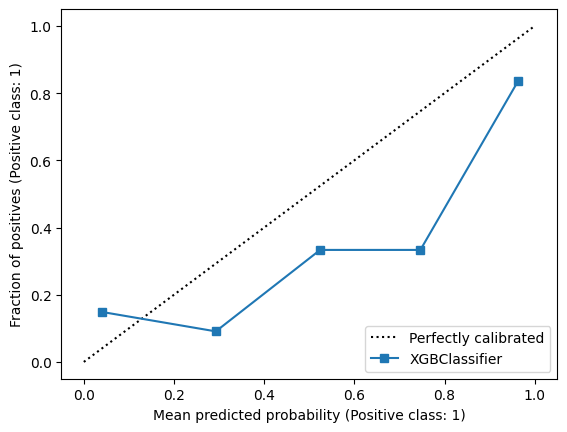

In [108]:

X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

CalibrationDisplay.from_estimator(model_xgb, X_validate, y_validate)


Text(0.5, 1.0, 'XGBoost - Calibrated')

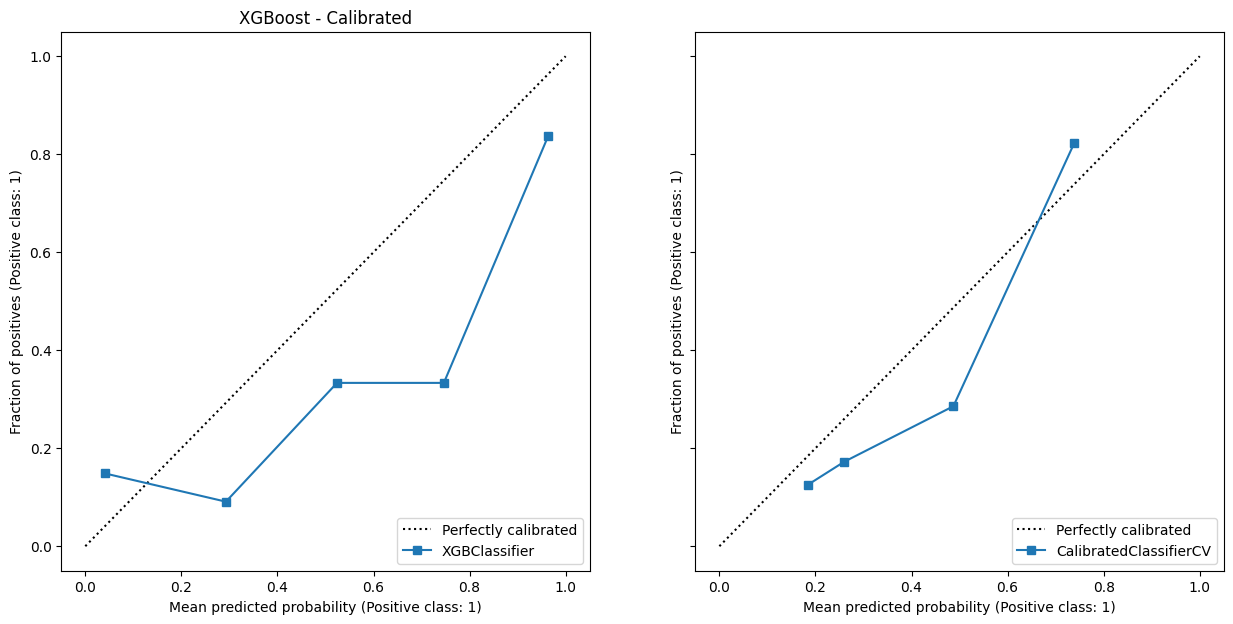

In [113]:
from sklearn.calibration import CalibratedClassifierCV

model_xgb_calibrated = CalibratedClassifierCV(model_xgb, cv="prefit")
model_xgb_calibrated.fit(X_calibrate, y_calibrate)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharey=True, sharex=True)

CalibrationDisplay.from_estimator(model_xgb, X_validate, y_validate, ax=ax1)
ax1.set_title("XGBoost")
CalibrationDisplay.from_estimator(model_xgb_calibrated, X_validate, y_validate, ax=ax2)
ax1.set_title("XGBoost - Calibrated")


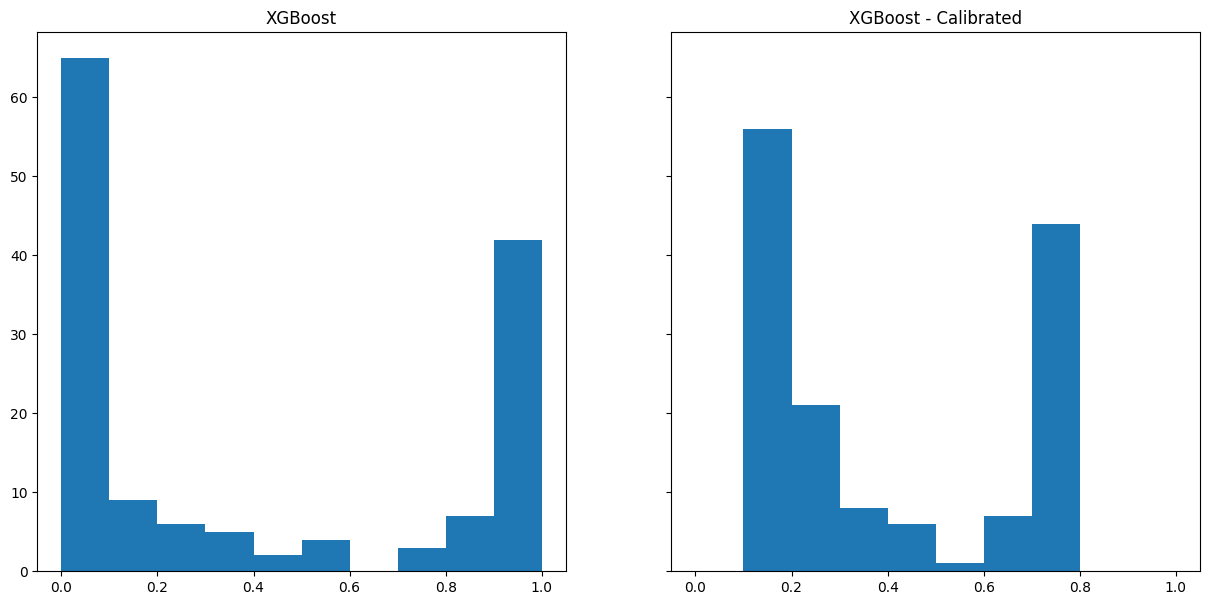

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharey=True, sharex=True)

#######################
# XGBoost             #
#######################

ax1.hist(model_xgb.predict_proba(X_validate)[:,1], bins=np.arange(0,1.01,0.1))
ax1 = ax1.set_title("XGBoost")

########################
# XGBoost - Calibrated #
########################

ax2.hist(model_xgb_calibrated.predict_proba(X_validate)[:,1], bins=np.arange(0,1.01,0.1))
ax2 = ax2.set_title("XGBoost - Calibrated")

# Compare performance

In [129]:
def pred_assess(name, model=XGBClassifier(random_state=42),
              X_train=X_train, X_validate=X_validate, y_train=y_train, y_validate=y_validate,
              show_confusion_matrix=False
              ):

     y_pred_train = model.predict(X_train)
     y_pred_val = model.predict(X_validate)

     if show_confusion_matrix:
          confusion_matrix_titanic = ConfusionMatrixDisplay(
               confusion_matrix=confusion_matrix(
                    y_true=y_validate,
                    y_pred=y_pred_val,
                    normalize='true'
                    ),
                    display_labels=["Died", "Survived"]
               )

          confusion_matrix_titanic.plot()

     return pd.DataFrame({
          'Accuracy (training)': np.mean(y_pred_train == y_train).round(4),
          'Accuracy (validation)': np.mean(y_pred_val == y_validate).round(4),
          'Precision (validation)': precision_score(y_validate, y_pred_val, average='macro').round(4),
          'Recall (validation)': recall_score(y_validate, y_pred_val, average='macro').round(4),
          'features': ", ".join(X_train.columns.tolist())

          }, index=[name]
)

In [124]:
pd.concat(
    [pred_assess(model=model_xgb, name="XBoost"),
     pred_assess(model=model_xgb_calibrated, name="XBoost - Calibrated")]
     )

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),features
XBoost,0.989,0.8322,0.8239,0.8239,"Pclass, Age, SibSp, Parch, Fare, AgeImputed, E..."
XBoost - Calibrated,0.989,0.8322,0.8269,0.8175,"Pclass, Age, SibSp, Parch, Fare, AgeImputed, E..."


,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),features
XGBoost,0.989,0.8322,0.8239,0.8239,"Pclass, Age, SibSp, Parch, Fare, AgeImputed, E..."


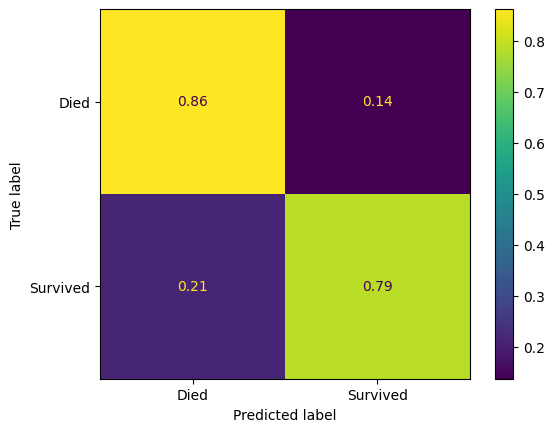

In [130]:
pred_assess(model=model_xgb, name="XGBoost", show_confusion_matrix=True)

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),features
XGBoost - calibrated,0.989,0.8322,0.8269,0.8175,"Pclass, Age, SibSp, Parch, Fare, AgeImputed, E..."


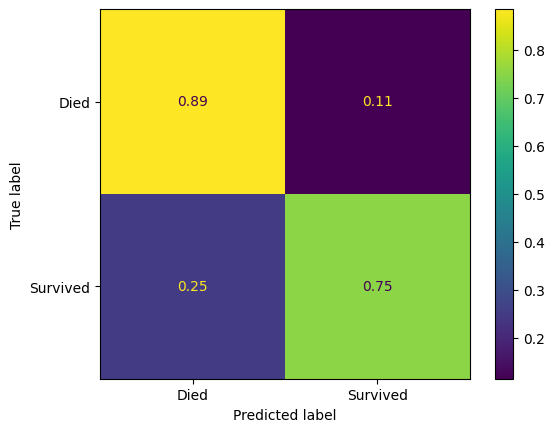

In [131]:
pred_assess(model=model_xgb_calibrated, name="XGBoost - calibrated", show_confusion_matrix=True)